<a href="https://colab.research.google.com/github/Saifullah785/deep-learning-projects/blob/main/Project_11_dog_breeds_detection_transfer_learning/Project_11_dog_breeds_detection_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load all Packages

In [ ]:
# Install Kaggle library
# !pip install kaggle

In [7]:
# Set up Kaggle API token
# upload kaggle API token: then proceed
# move api token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Download and unzip the dog breeds dataset
# download dataset
!kaggle datasets download -d 'mohamedchahed/dog-breeds'
# unzip dataset
!unzip dog-breeds.zip

In [9]:
# Import required libraries
import os
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

# Data Augmentation

In [10]:
# Initialize ImageDataGenerator for data augmentation
# creating IMageDataGenerator instance to Augment,split and then pass our images to the model

data_gen = ImageDataGenerator(rescale = 1./255,
                              width_shift_range = 0.2,
                              validation_split= 0.1,
                              height_shift_range= 0.2,
                              shear_range = 0.2,
                              horizontal_flip = True,
                              vertical_flip = True,
                              zoom_range = 0.2)

#Applying Data Augementation On both training and validation sets

In [11]:
# Create training and validation data generators
# Creating our test and validation data generator to flow images to network from images directory

training_data = data_gen.flow_from_directory('/content/dog-breeds',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             subset = 'training')

validation_data = data_gen.flow_from_directory('/content/dog-breeds',
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               subset = 'validation')

Found 490 images belonging to 8 classes.
Found 51 images belonging to 8 classes.


# Downloading a Pretrained InceptionV3 Model by URL

In [ ]:
# Download pre-trained InceptionV3 weights
# Downloading the pre-trained weights.
# No top means it excludes the fully connected layer it uses for classification. we only need convolution layers.

# In colab or kaggle notebook use the following
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O //content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


# Transfer Learning Intialization and Configuration

In [13]:
# Initialize and configure InceptionV3 for transfer learning
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you download into a variable
local_weights_file = '/content/sample_data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


# Initialize the base model.
# Set the input shape and remove the dense layers.

pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of th layers
# As said before we don't want to re-train model's convolutional layers
for layer in pre_trained_model.layers:
  layer.trainable = False

In [14]:
# Define the last layer of the pre-trained model
# Choose 'mixed_7' as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


# Model Architecture

In [15]:
# Define and summarize the model architecture
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                        # This Has Regularization effects
# Add a final sigmoid layer for classification
x = layers.Dense  (8, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 122,230,696 (466.27 MB)

 Trainable params: 113,255,432 (432.04 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

# Model Compilation

In [16]:
# Define learning rate schedule and compile the model
# define the set of callbacks to be passed to the model during training
# defining our scheduler
def step_decay(epoch):
    # initialize the base initial learning rate, drop factor, and
    # epochs to drop every
    initial_alpha = 0.01
    factor = 0.5
    drop_every_epoch = 5
    # compute learning rate for the current epoch
    alpha = initial_alpha * (factor ** np.floor((1+epoch) / drop_every_epoch))
    # return the learning rate
    return float(alpha)

callbacks = [LearningRateScheduler(step_decay)]

# initialize optimizer and model
print("[INFO] compiling model...")

opt = SGD(learning_rate=0.01,momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

[INFO] compiling model...


# Model Training

In [17]:
# Train the model
# Traint the model..
history = model.fit(
    training_data,
    validation_data = validation_data,
    epochs = 20,
    callbacks = callbacks,
    verbose = 1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1559 - loss: 5.2043 - val_accuracy: 0.2745 - val_loss: 1.9582 - learning_rate: 0.0100
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 731ms/step - accuracy: 0.3615 - loss: 1.7305 - val_accuracy: 0.5294 - val_loss: 1.2733 - learning_rate: 0.0100
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 715ms/step - accuracy: 0.6477 - loss: 1.0769 - val_accuracy: 0.7059 - val_loss: 0.8429 - learning_rate: 0.0100
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 735ms/step - accuracy: 0.6880 - loss: 0.8484 - val_accuracy: 0.8235 - val_loss: 0.4267 - learning_rate: 0.0100
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 725ms/step - accuracy: 0.7693 - loss: 0.6140 - val_accuracy: 0.8627 - val_loss: 0.3794 - learning_rate: 0.0050
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 731ms/step - accuracy: 0.8573 - loss: 0.4037 - val_accuracy: 0.8627 - val_loss: 0.4426 - learning_rate: 0.0050
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 721ms/step - accuracy: 0.8730 - loss: 0.408

# Plot the Training Loss and Accuracy

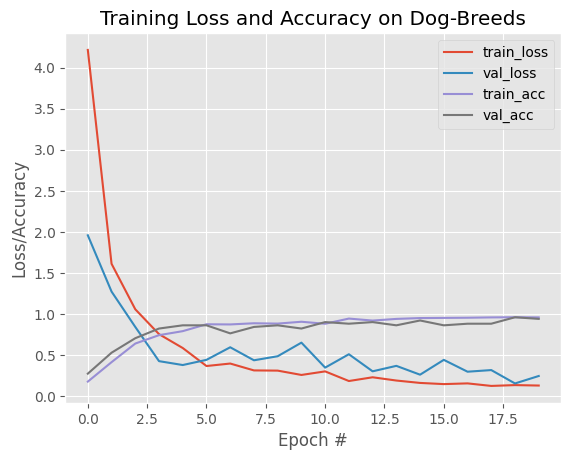

In [18]:
# Plot training loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, 20), history.history['loss'], label='train_loss')
plt.plot(np.arange(0, 20), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, 20), history.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 20), history.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy on Dog-Breeds')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


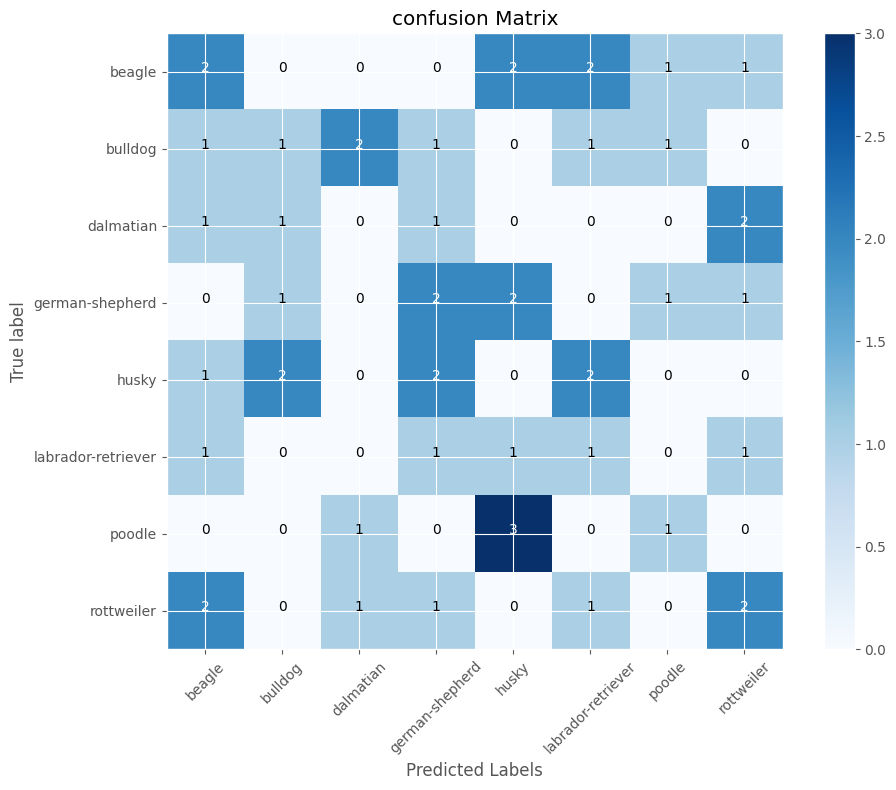

In [19]:
# Generate and plot the confusion matrix
# Generate predictions on the validation set
from sklearn.metrics import confusion_matrix
y_pred = model.predict(validation_data)

# convert predictions from one-hot encoded formate to class labels
y_pred_labels = np.argmax(y_pred, axis=1);

# get true labels from the validaion data generator
true_labels = validation_data.classes;

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels);

# plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')

#Add title and axis labels
plt.title('confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True label')

# Add tick marks and labels
tick_marks = np.arange(len(validation_data.class_indices))
plt.xticks(tick_marks, validation_data.class_indices, rotation=45)
plt.yticks(tick_marks, validation_data.class_indices)

# Add text annotations
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if conf_matrix[i, j] > thresh else 'black')

# show plot
plt.colorbar()
plt.tight_layout()
plt.show()

# Save and Load Model

In [22]:
# Save the trained model
# Save the model
#Save the model
model.save('/content/drive/MyDrive/fine_tuned_inception.h5')




In [23]:
# Load the saved model
# Load the saved model
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/fine_tuned_inception.h5')

# Predictive System

In [26]:
# Define a function for image prediction and display
from tensorflow.keras.preprocessing import image

def predict_and_display(model, class_labels, img_path, true_class=None):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Make predictions
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence_level = np.max(predictions)

    # Decode the predicted class
    predicted_class_name = class_labels[predicted_class]

    # Display the image
    plt.imshow(img)
    plt.axis('off')

    # Display the predicted class and confidence level
    if true_class:
        plt.title(f'Predicted Class: {predicted_class_name}, True Class: {true_class}')
    else:
        plt.title(f'Predicted Class: {predicted_class_name}')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


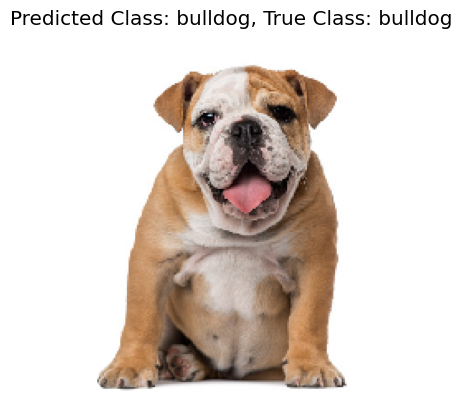

In [27]:
# Perform prediction on a sample image
# Assuming you have already defined your model, class labels, and image path

class_labels = ['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']
predict_and_display(model, class_labels, '/content/dog-breeds/bulldog/bulldog108.jpg', true_class='bulldog')